In [1]:
# imports
import math
import statistics
import astropy as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


In [2]:
# set filepaths
filepath = '/Users/gilliancartwright/Desktop/DES data/'
filename = filepath + 'Rob_candidates_larger.fits'


In [3]:
# define some functions
def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.close()


def plot_all(coadd_id, image):
    """
    Input: coadd_id and image array (num_images, num_bands=3, numpix, numpix)
    Output: RGB image, and G, R, I plots for single image (indexed by coadd_id)
    """
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    ax[0].imshow(rgb_image, origin='lower')  # RGB
    ax[0].set_title('RGB')

    ax[1].imshow(image[row, 0, :, :], cmap='gray', origin='lower')  # g-band
    ax[1].set_title('G-BAND')

    ax[2].imshow(image[row, 1, :, :], cmap='gray', origin='lower')  # r-band
    ax[2].set_title('R-BAND')

    ax[3].imshow(image[row, 2, :, :], cmap='gray', origin='lower')  # i-band
    ax[3].set_title('I-BAND')

    plt.tight_layout()
    plt.show()
    plt.close()


def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


In [4]:
# show data table for reference
data, image = get_data(filename)
coadd_id = 1400263522
data.head(3)


,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,...,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z,NAME,NAME_FOLDER
0,1400263522,DES0336-2915,2354916223,147182263,0.938449,53.898900,-28.912203,3.962615,4.879757,4.983489,...,1.09654,0.943639,0.817035,0.899360,390.652008,947.728027,3299.189941,7099.970215,DES-691022126,DES0336-2915
1,1325853948,DES0242-0041,1163420627,72713789,0.006323,40.969310,-0.619002,10.245866,10.665524,11.179090,...,1.09442,0.956736,0.894366,0.889644,459.313995,1283.849976,3451.110107,8414.360352,DES-701263907,DES0242-0041
2,1087262176,DES0038-4414,2318857161,144928572,0.545765,10.155908,-44.437518,5.865641,5.180269,5.163048,...,1.28928,1.035290,1.025070,0.777657,406.477997,1063.030029,2966.409912,8586.750000,DES-699919273,DES0038-4414


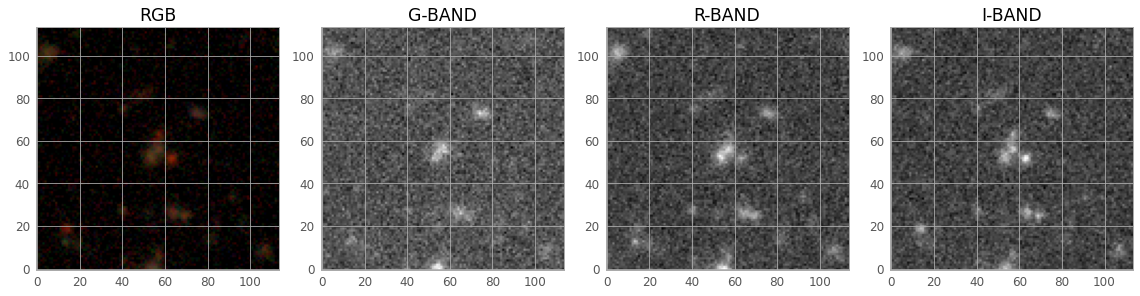

In [5]:
# plot all with grid
plot_all(coadd_id, image)


In [6]:
# select region for background
# must be integers!
crop = [[85, 114], [85, 114]]


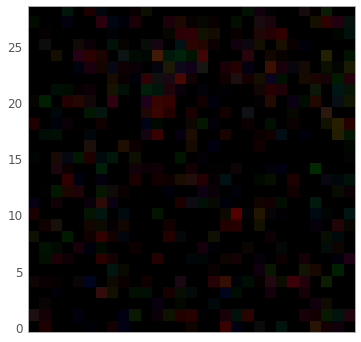

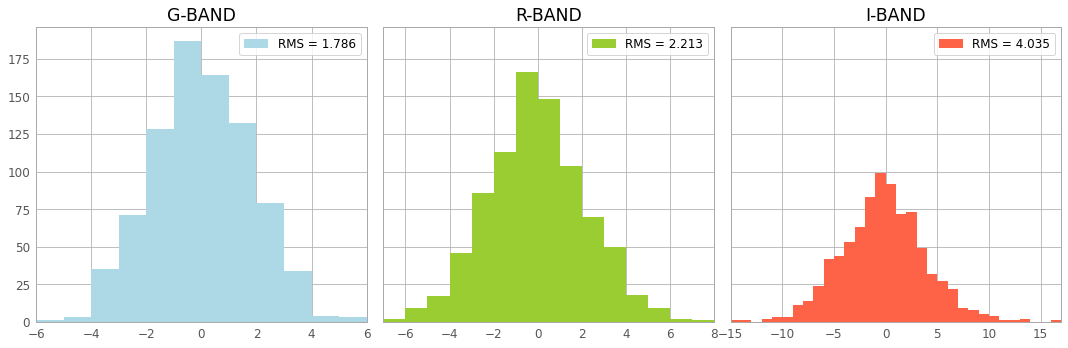

In [7]:
def get_rms(filename, coadd_id, crop):
    """
    Long Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: RGB image of region to check that selected region is good,
            histogram for each band, returns rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    rgb_crop = ap.visualization.make_lupton_rgb(i_crop, r_crop,
                                                g_crop, stretch=50, Q=10)
    plot_image(rgb_crop)  # check rgb image

    g_flat = g_crop.flatten()  # make 2d image array into 1d np array
    r_flat = r_crop.flatten()
    i_flat = i_crop.flatten()

    rms_list = []  # each rms value will be saved here and returned

    # set up figure and axes for plotting
    f, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # settings for each band (flattened image, index, plot title and color)
    band_flats = [g_flat, r_flat, i_flat]  # combine flattened images into list
    band_index = range(len(band_flats))  # make list of band indices
    band_names = ['G-BAND', 'R-BAND', 'I-BAND']  # set band labels
    band_colors = ['lightblue', 'yellowgreen', 'tomato']  # set plot colors
    combined_lists = zip(band_flats, band_index, band_names, band_colors)

    # loop to set ax for each band
    for flat_image, index, name, color in combined_lists:
        Bins, min_int, max_int, rms = get_hist_stats(flat_image)  # get stats
        rms_list.append(rms)  # save rms

        # create ax for g,r,i bands
        ax[index].hist(flat_image, bins=Bins, range=(min_int, max_int),
                       color=color, label='RMS = '+str(round(rms, 3)))
        ax[index].set_title(name)  # show title
        ax[index].set_xlim(xmin=min_int, xmax=max_int)
        ax[index].legend()  # show rms in legend rounded to 3 decimals

    plt.tight_layout()
    plt.show()
    plt.close()
    return rms_list


rms_list = get_rms(filename, coadd_id, crop)


In [10]:
def get_rms_fast(filename, coadd_id, crop):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list

rms_list = get_rms_fast(filename, coadd_id, crop)
print(rms_list)


[1.786096284428651, 2.2134472834997894, 4.0349931259410985]
